# [0] Pairs Trading

## Background Information:

Pairs trading is a mean-reversion strategy that offers the advantage of being constantly hedged against market movements. It becomes a high alpha strategy when supported by robust statistical analysis and is based on mathematical principles. The strategy involves trading a pair of securities, such as X and Y, that have a recognized economic connection, such as manufacturing the same product or being part of the same supply chain.

To grasp pairs trading, one must comprehend three key mathematical concepts: Stationarity, Integration, and Cointegration.

# [1] Import Packages

In [ ]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

# [2] Stationarity/ Non-Stationarity

Stationarity is the most commonly untestedassumption in time series analysis. We generally assume that data is stationary when the parameters of the data generating process do not change over time. Else consider two series: A and B. Series A will generate a stationary time series with fixed parameters, while B will change over time.

Stationarity is important because most statistical tests require that data being tested are stationary.

In [ ]:
def generate_data(params):
    mu = params[0]
    sigma = params[1]
    # np.random.normal is more likely to return samples lying close to
    # the mean, rather than those that are far away.
    return np.random.normal(mu, sigma)

We will create two plots that exhibit stationary and non-stationary time series.

<ipython-input-3-bb70b7bd28b1>:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  A = pd.Series(index=range(T))
<ipython-input-3-bb70b7bd28b1>:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  B = pd.Series(index=range(T))


Text(0.5, 1.0, 'Non-Stationary')

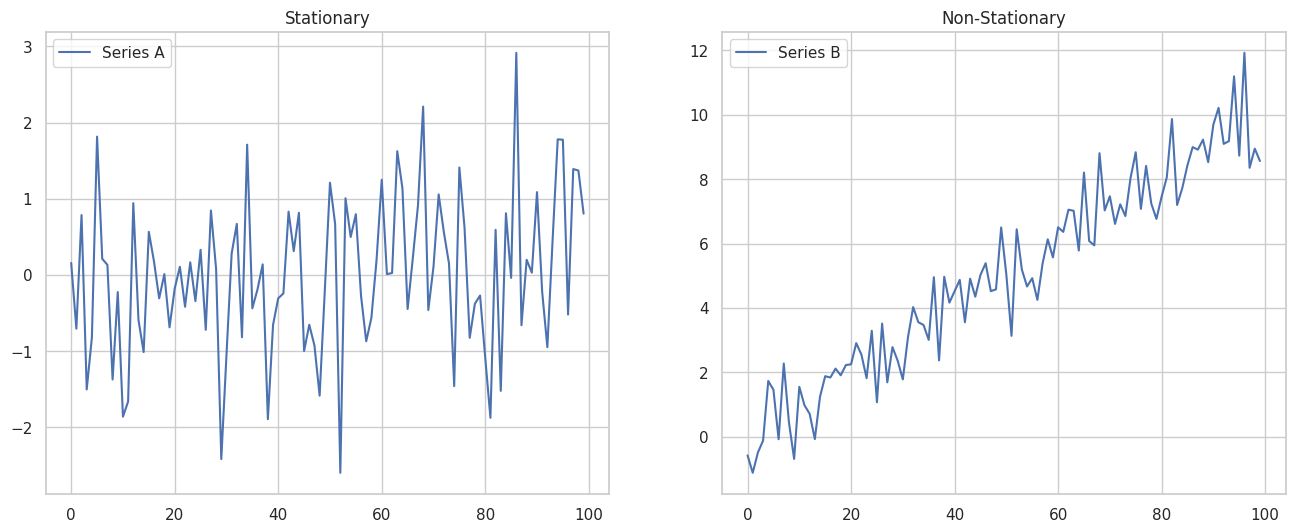

In [ ]:
# Set the parameters and the number of datapoints
params = (0, 1)
T = 100

A = pd.Series(index=range(T))
A.name = 'A'

for t in range(T):
    A[t] = generate_data(params)

T = 100

B = pd.Series(index=range(T))
B.name = 'B'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (t * 0.1, 1)
    B[t] = generate_data(params)

fig, (ax1, ax2) = plt.subplots(nrows =1, ncols =2, figsize=(16,6))

ax1.plot(A)
ax2.plot(B)
ax1.legend(['Series A'])
ax2.legend(['Series B'])
ax1.set_title('Stationary')
ax2.set_title('Non-Stationary')

Let's tale an average of our non-stationary time series B.

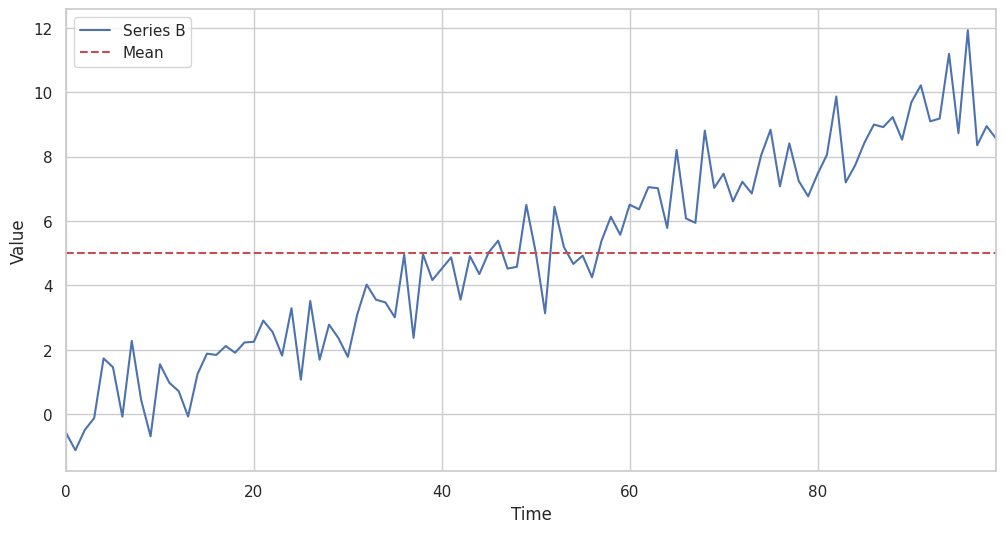

In [ ]:
mean = np.mean(B)

plt.figure(figsize=(12,6))
plt.plot(B)
plt.hlines(mean, 0, len(B), linestyles='dashed', colors = 'r')
plt.xlabel('Time')
plt.xlim([0, 99])
plt.ylabel('Value')
plt.legend(['Series B', 'Mean'])

The mean of our non-stationary time series is **useless** because it won't be useful in terms of forecasting any future state.

**How to test for Stationarity?**

*Augmented Dickey Fuller Test*

The Augmented Dickey-Fuller (ADF) test is a statistical test used to assess whether a time series data is stationary or not. Stationarity is an important concept in time series analysis because many statistical models and forecasting techniques assume that the data is stationary, meaning that its statistical properties do not change over time.

Here's an intuitive explanation of how the ADF test works and how it tests for stationarity:

Null Hypothesis (H0): The null hypothesis of the ADF test assumes that the time series data has a unit root, meaning it is non-stationary. In other words, it assumes that the data exhibits a trend and its statistical properties change over time.

Alternative Hypothesis (H1): The alternative hypothesis (what we want to prove) is that the time series data is stationary. In this case, it means that the data does not have a unit root and behaves in a stable manner over time.

Test Statistic: The ADF test calculates a test statistic that measures how strongly the data deviates from stationarity. It does this by regressing the current value of the time series on its lagged values (previous observations) and testing whether the coefficient of the lagged values is significantly different from zero. If the coefficient is close to zero, it suggests that the data is stationary. If the coefficient is significantly different from zero, it suggests non-stationarity.

Critical Values: The ADF test compares the calculated test statistic to critical values from a specific statistical distribution (usually a normal distribution). These critical values depend on the sample size and the significance level chosen for the test. If the test statistic is more extreme (either more negative or more positive) than the critical values, we can reject the null hypothesis in favor of the alternative hypothesis.

Interpretation: If the ADF test statistic is less extreme than the critical values (i.e., it falls within the critical region), we fail to reject the null hypothesis, indicating that the data is likely non-stationary. On the other hand, if the test statistic is more extreme than the critical values, we reject the null hypothesis in favor of stationarity, suggesting that the data is likely stationary.

In [ ]:
def stationarity_test(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')

In [ ]:
stationarity_test(A)
stationarity_test(B)

p-value = 3.9601126792916515e-16 The series A is likely stationary.
p-value = 0.7507722364908022 The series B is likely non-stationary.


As we can see, based on the test statistic (which correspnds with a specific p-value) for time series A, we can fail to reject the null hypothesis. As such, Series A is likely to be stationary. On the other hand, Series B is rejected by the hypothesis test, so this time series is likely to be non-stationary.

# [3] Cointegration

The correlations between financial quantities are notoriously unstable. Nevertheless, correlations are regularly used in almost all multivariate financial problems. An alternative statistical measure to correlation is cointegration. This is probably a more robust measure of linkage between two financial quantities, but as yet there is little derviaties theory based on this concept.

Two stocks may be perfectly correlated over short timescales, yet diverge in the long run, with one growing and the other decaying. Conversely, two stocks may follow each other, never being more than a certain distance apart, but with any correlation, positive negaative or varying. If we are delta hedging, then maybe the short timescale correlation matters, but not if we are holding stocks for a long time in an unhedged portfolio.

Here is an example of two cointegrated series:

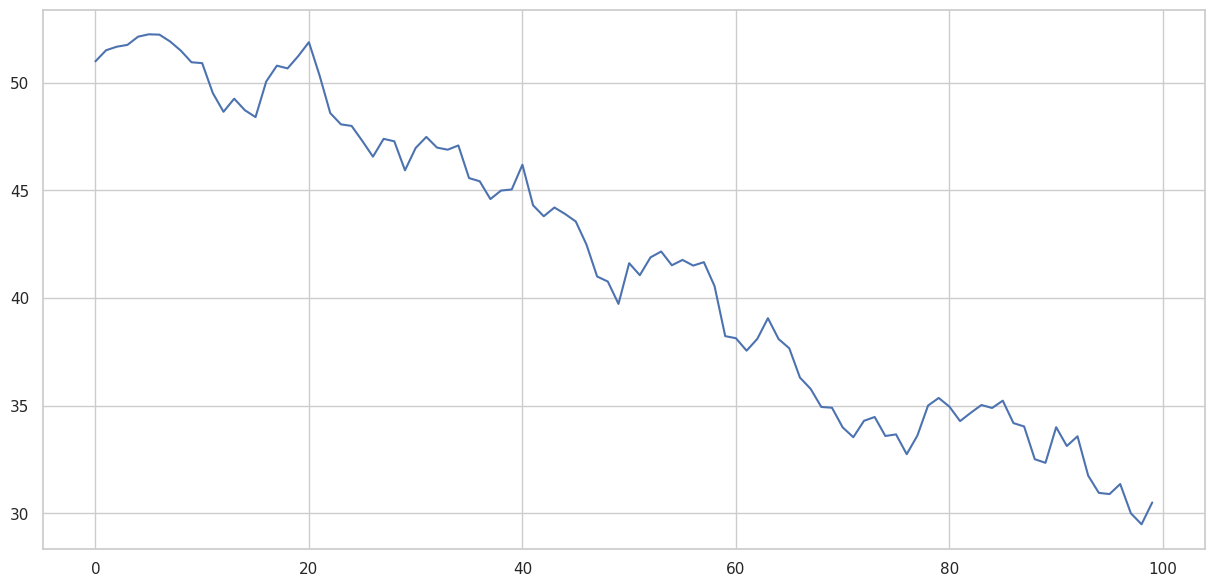

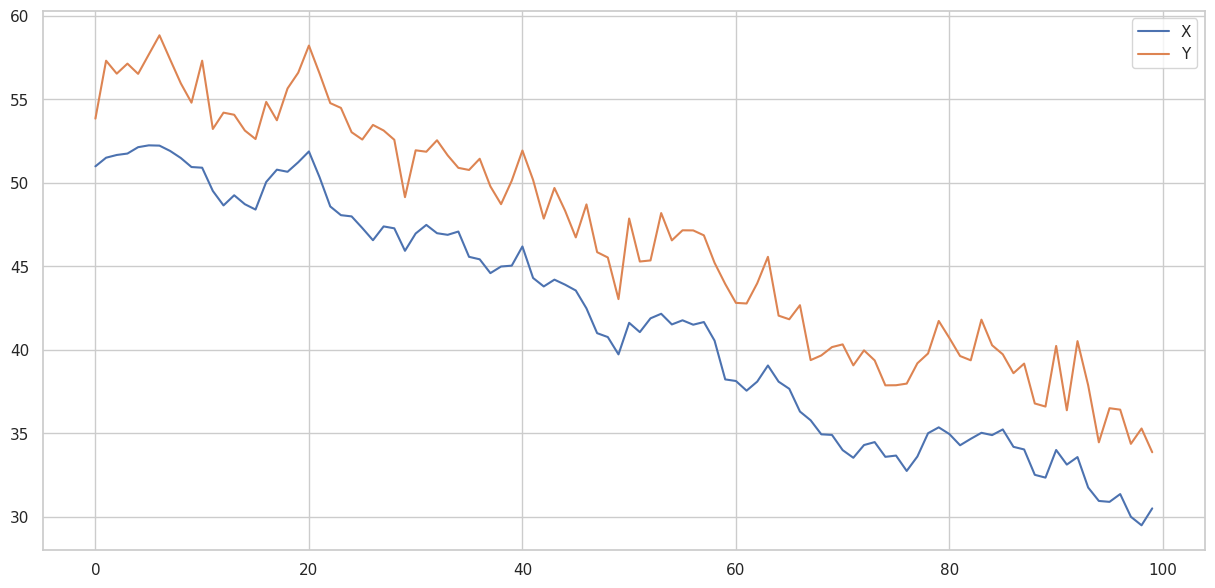

In [ ]:
# Generate daily returns

Xreturns = np.random.normal(0, 1, 100)

# sum up and shift the prices up

X = pd.Series(np.cumsum(
    Xreturns), name='X') + 50
X.plot(figsize=(15,7))

noise = np.random.normal(0, 1, 100)
Y = X + 5 + noise
Y.name = 'Y'

pd.concat([X, Y], axis=1).plot(figsize=(15, 7))

plt.show()

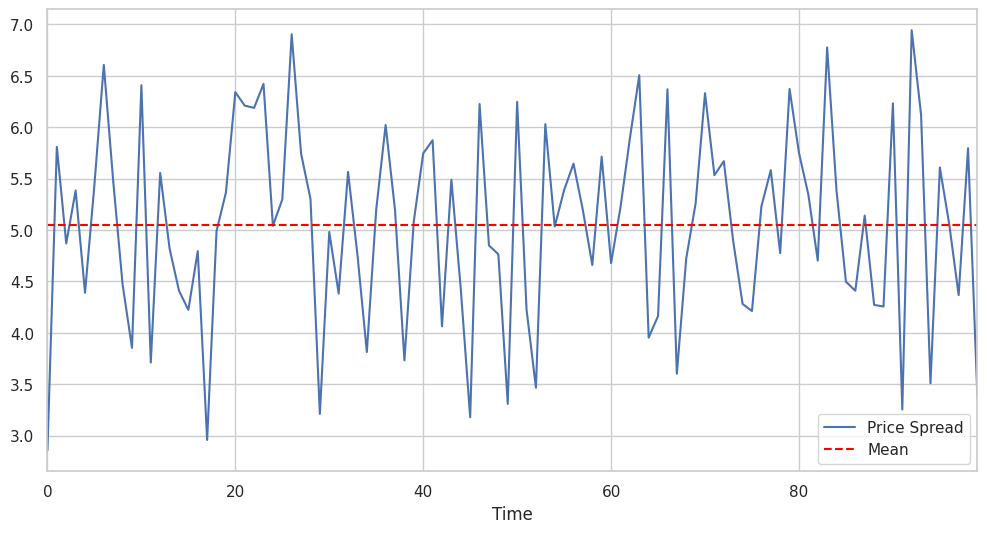

In [ ]:
plt.figure(figsize=(12,6))
(Y - X).plot() # Plot the spread
plt.axhline((Y - X).mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.ylabel('Price Spread [Y - X]')
plt.xlim(0,99)
plt.legend(['Price Spread', 'Mean']);

**Testing for Cointegration**

Procedure:
1. Test for a unit root in each component series individually, using the univariate unit root tests, say ADF, PP test.
2. If the unit root cannot be rejected, then the next step is to test cointegration among the components, i.e., to test whether (alpha*^Y_t) is I(0).

Three Methods for Testing Cointegration:
Johansen, Engle-Granger, and Phillips-Ouliaris

In [ ]:
score, pvalue, _ = coint(X,Y)
print(pvalue)

# Low pvalue means high cointegration!

7.156458532021371e-19


# [3] Correlation vs Cointegration

Example of Two time Series that are Correlated, but not Cointegrated (i.e. a simple example where two series diverge)

(0.0, 99.0)

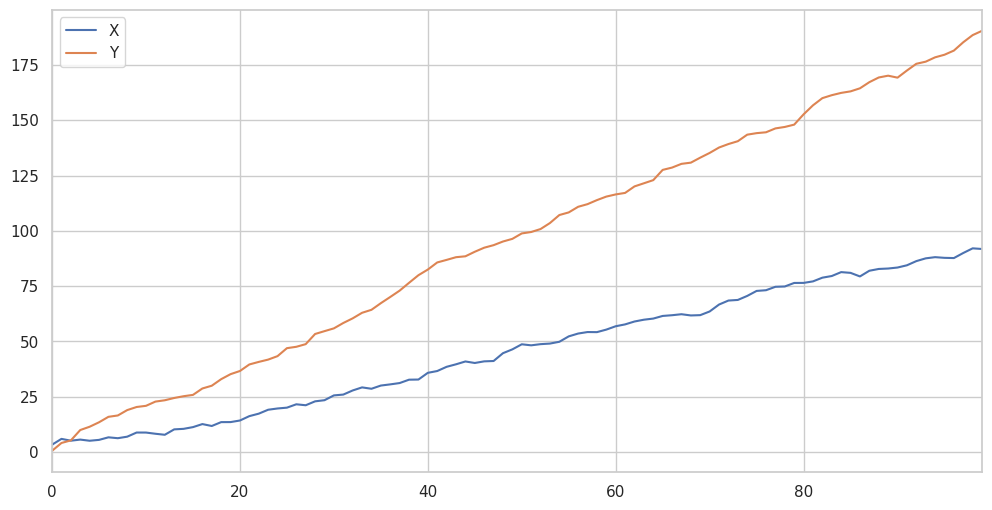

In [ ]:
X_returns = np.random.normal(1, 1, 100)
Y_returns = np.random.normal(2, 1, 100)

X_diverging = pd.Series(np.cumsum(X_returns), name='X')
Y_diverging = pd.Series(np.cumsum(Y_returns), name='Y')

pd.concat([X_diverging, Y_diverging], axis=1).plot(figsize=(12,6));
plt.xlim(0, 99)

Comparing the correlation coefficient with the cointegration test p-value

In [ ]:
print('Correlation: ' + str(X_diverging.corr(Y_diverging)))
score, pvalue, _ = coint(X_diverging,Y_diverging)
print('Cointegration test p-value: ' + str(pvalue))

Correlation: 0.9976208156264892
Cointegration test p-value: 0.02790262027898567


As we can see, there is a very strong (nearly perfect) correlation between series X and Y. However, our p-value for the cointegration test yields a result of 0.9481, which means there is no cointegration between time series X and Y.

Example #2: A Normally Distributed Time Series and a Square Wave (i.e. an example of perfect cointegration, that is, a p-value of 0, and little to no correlation)

Correlation: 0.01253763583848245
Cointegration test p-value: 0.0


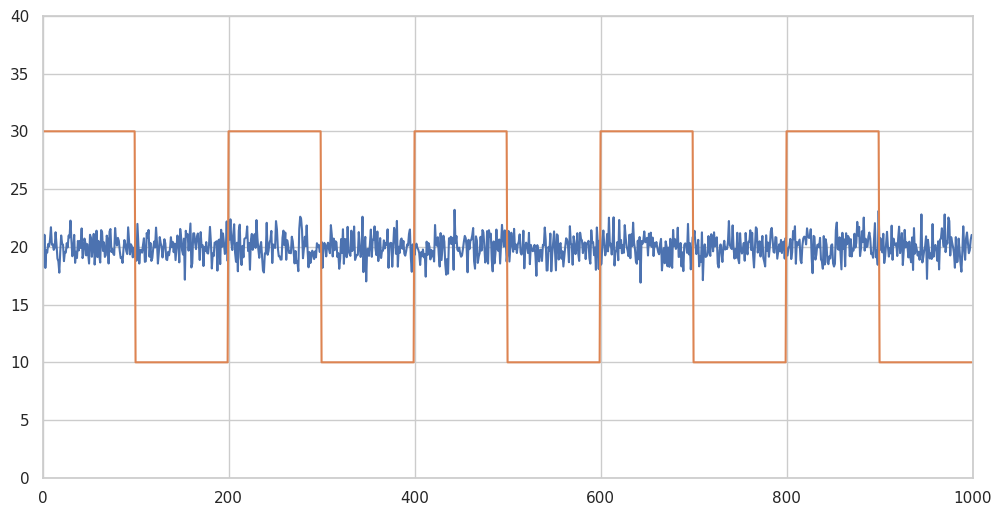

In [ ]:

Y2 = pd.Series(np.random.normal(0, 1, 1000), name='Y2') + 20
Y3 = Y2.copy()

# Y2 = Y2 + 10
Y3[0:100] = 30
Y3[100:200] = 10
Y3[200:300] = 30
Y3[300:400] = 10
Y3[400:500] = 30
Y3[500:600] = 10
Y3[600:700] = 30
Y3[700:800] = 10
Y3[800:900] = 30
Y3[900:1000] = 10


plt.figure(figsize=(12,6))
Y2.plot()
Y3.plot()
plt.ylim([0, 40])
plt.xlim([0, 1000]);

# correlation is nearly zero
print( 'Correlation: ' + str(Y2.corr(Y3)))
score, pvalue, _ = coint(Y2,Y3)
print( 'Cointegration test p-value: ' + str(pvalue))

Although the correlation is incredibly low, the p-value shows that these time series are cointegrated.

# [4] Trading Example

Import Packages

In [ ]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
yf.pdr_override()

Function to find cointegrated security pairs:

In [ ]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

We are looking through a set of tech companies to see if any of them are cointegrated.

We'll start by defining the list of securities we want to look through. Then we'll get the pricing data for each security from the year 2013 - 2018.

As mentioned before, we have formulated an economic hypothesis that there is some sort of link between a subset of securities within the tech sector and we want to test whether there are any cointegrated pairs. This incurs significantly less multiple comparisons bias than searching through hundreds of securities and slightly more than forming a hypothesis for an individual test.

In [ ]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2018, 1, 1)

tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']


df = pdr.get_data_yahoo(tickers, start, end)['Close']
df.tail()

[*********************100%%**********************]  11 of 11 completed


,AAPL,ADBE,AMD,EBAY,HPQ,IBM,JNPR,MSFT,ORCL,QCOM,SPY
Date,,,,,,,,,,,
2017-12-22,43.752499,175.000000,10.54,37.759998,21.26,145.793503,28.860001,85.510002,47.360001,64.730003,267.510010
2017-12-26,42.642502,174.440002,10.46,37.939999,21.23,146.108994,28.860001,85.400002,47.430000,64.300003,267.190002
2017-12-27,42.650002,175.360001,10.53,37.610001,21.27,146.395798,28.879999,85.709999,47.380001,64.540001,267.320007
2017-12-28,42.770000,175.550003,10.55,37.919998,21.15,147.265778,28.870001,85.720001,47.520000,64.379997,267.869995
2017-12-29,42.307499,175.240005,10.28,37.740002,21.01,146.673035,28.500000,85.540001,47.279999,64.019997,266.859985


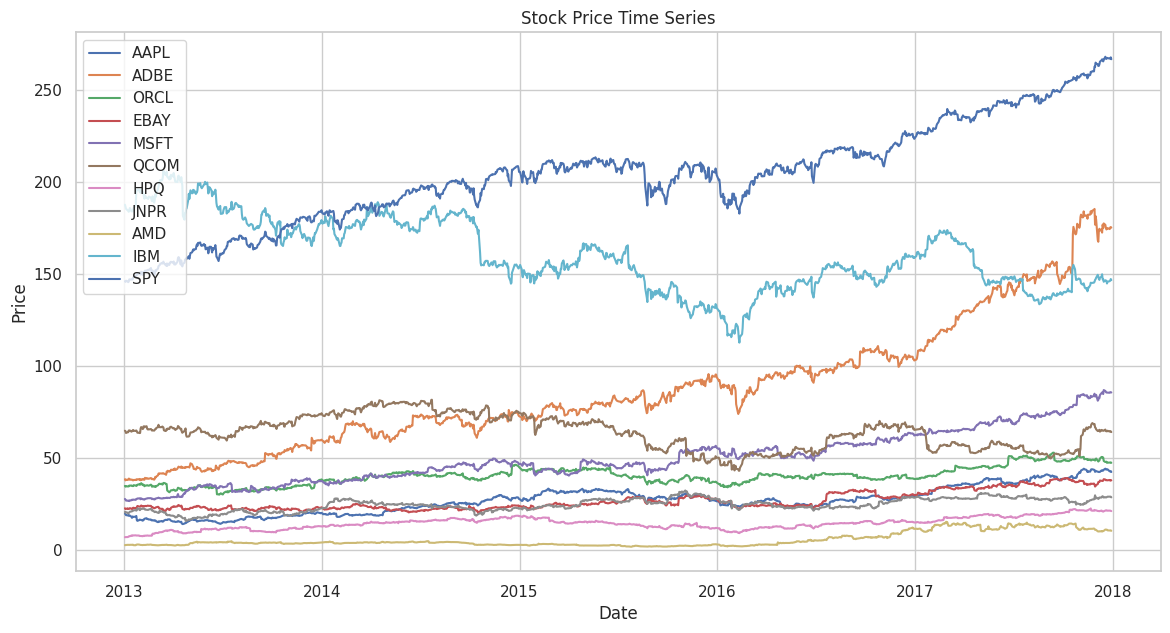

In [ ]:
import matplotlib.pyplot as plt

def plot_stock_time_series(df, tickers):
    """
    Plot the time series for the given stocks.

    Parameters:
    df : DataFrame
        A DataFrame where each column represents the price series of a stock
        and each row corresponds to a date.
    tickers : list
        List of stock ticker symbols to be plotted.
    """
    plt.figure(figsize=(14, 7))

    for ticker in tickers:
        if ticker in df.columns:
            plt.plot(df.index, df[ticker], label=ticker)
        else:
            print(f"Ticker {ticker} not found in the DataFrame columns.")

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Stock Price Time Series')
    plt.legend()
    plt.show()

tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']
plot_stock_time_series(df, tickers)

Heatmap to show the p-values of the cointegration test between each pair of
stocks. Only show the value in the upper-diagonal of the heatmap.

[('AAPL', 'SPY'), ('ADBE', 'EBAY'), ('ADBE', 'MSFT'), ('HPQ', 'ORCL')]


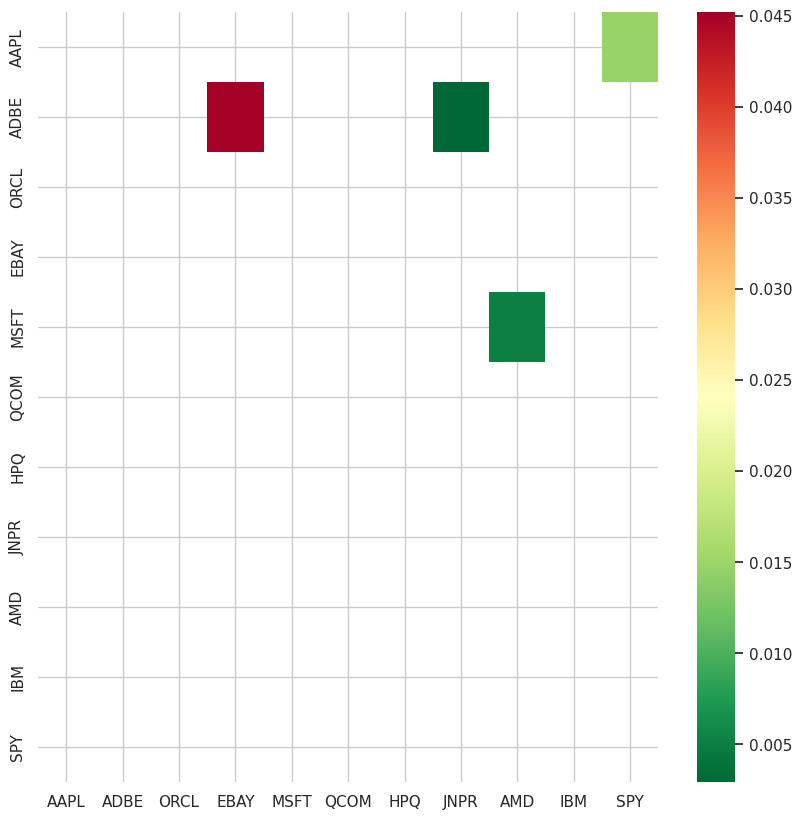

In [ ]:
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r'
                , mask = (pvalues >= 0.05)
                )
print(pairs)

Our algorithm listed two pairs that are cointegrated: AAPL/EBAY, and ABDE/MSFT. We can analyze their price patterns to make sure there is nothing weird going on.

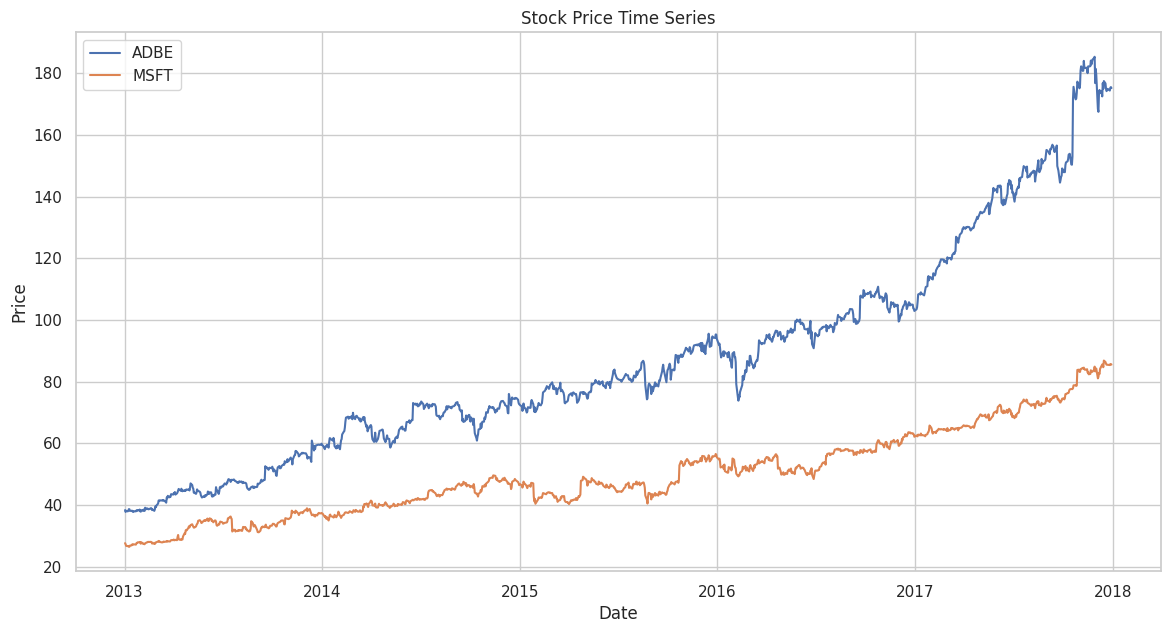

In [ ]:
tickers = ['ADBE', 'MSFT']
plot_stock_time_series(df, tickers)

In [ ]:
S1 = df['ADBE']
S2 = df['MSFT']

score, pvalue, _ = coint(S1, S2)
pvalue

0.0029504297644151662

**Calculating the Spread of the Two Time Series**

In order to actually calculate the spread, we use a linear regression to get the coefficient for the linear combination to construct between our two securities, as mentioned with the Engle-Granger method before.

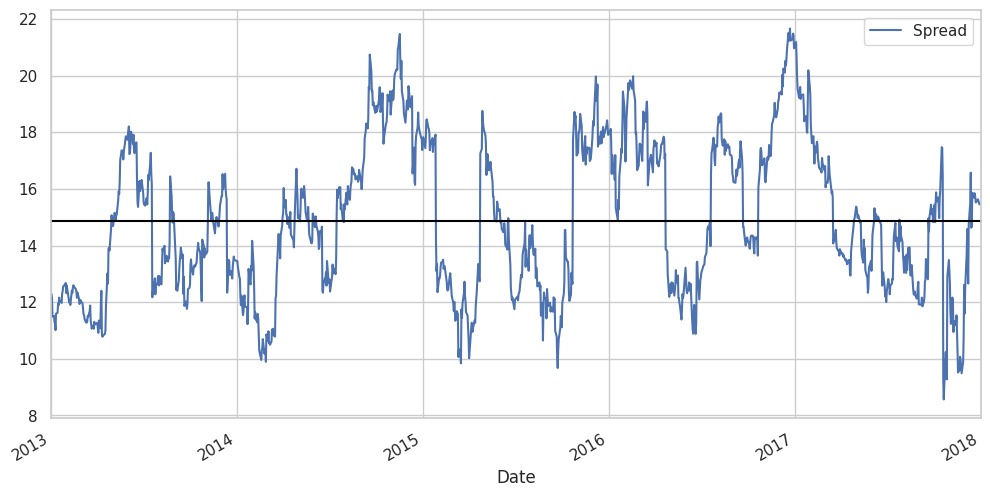

In [ ]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['ADBE']
b = results.params['ADBE']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Spread']);

**We can also examine the ratio between the two time series:**

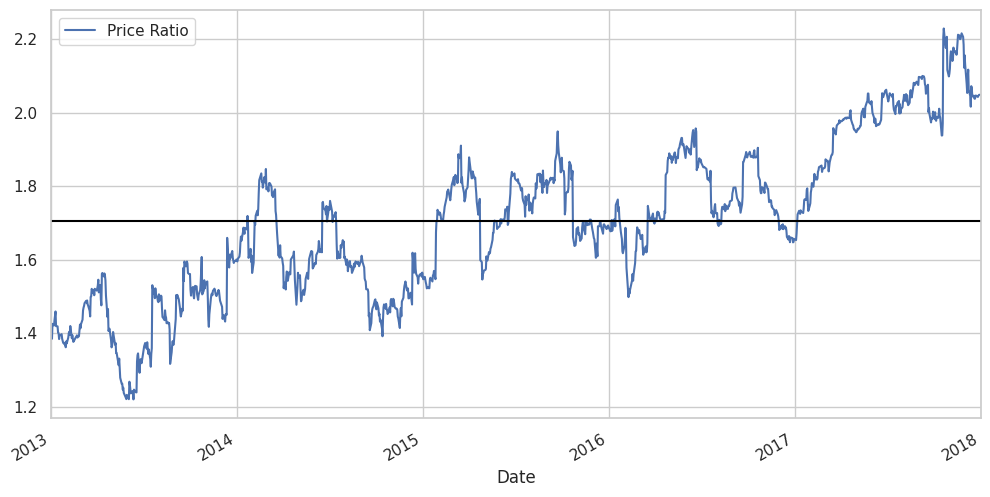

In [ ]:
ratio = S1/S2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Price Ratio']);

**Standardizing the Spread and Determining whether any Mean Reversion Exists between our Two Securities:**

Regardless of whether or not we use the spread approach or the ratio approach, we can see that our first plot pair ADBE/SYMC tends to move around the mean. We now need to standardize this ratio because the absolute ratio might not be the most ideal way of analyzing this trend. For this, we need to use z-scores.

A z-score is the number of standard deviations a datapoint is from the mean. More importantly, the nmber of standard deviations above or below the population mean is from the raw score. The z-score is calculated by the follow:

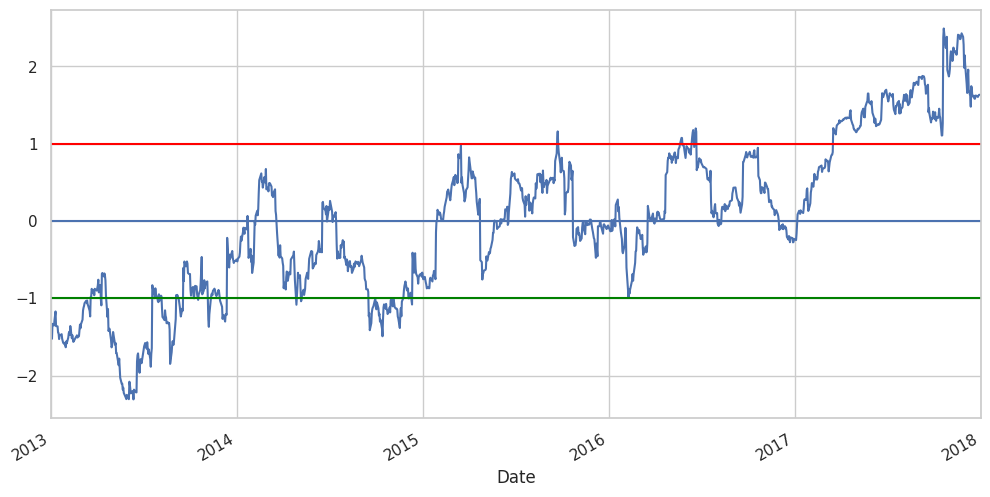

In [ ]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2013-01-01', '2018-01-01')
plt.show()

By setting two other lines placed at the z-score of 1 and -1, we can clearly see that for the most part, any big divergences from the mean eventually converges back. This is exactly what we want for a pairs trading strategy.

# [5] Trading Signals

When conducting any type of trading strategy, it's always important to clearly define and delineate at what point you will actually do a trade. As in, what is the best indicator that I need to buy or sell a particular stock?

**Rules for ADBE/MSFT Co-integration Example:**

We're going to use the ratio time series that we've created to see if it tells us whether to buy or sell a particular moment in time. We'll start off by creating a prediction variable
. If the ratio is positive, it will signal a "buy," otherwise, it will signal a sell.

What's great about pair trading signals is that we don't need to know absolutes about where the prices will go, all we need to know is where it's heading: up or down.

**Train-Test Split**

When training and testing a model, it's common to have splits of 70/30 or 80/20. We only used a time series of 252 points (which is the amount of trading days in a year). Before training and splitting the data, we will add more data points in each time series.

In [ ]:
# For this example, we will split the data into a train-test split of 70-30.
ratios = df['ADBE'] / df['MSFT']
print(len(ratios) * .70 )

881.3


In [ ]:
train = ratios[:881]
test = ratios[881:]

**Feature Engineering**

We need to find out what features are actually important in determining the direction of the ratio moves. Knowing that the ratios always eventually revert back to the mean, maybe the moving averages and metrics related to the mean will be important.

Let's try using these features:

- 60 day Moving Average of Ratio
- 5 day Moving Average of Ratio
- 60 day Standard Deviation
- z score

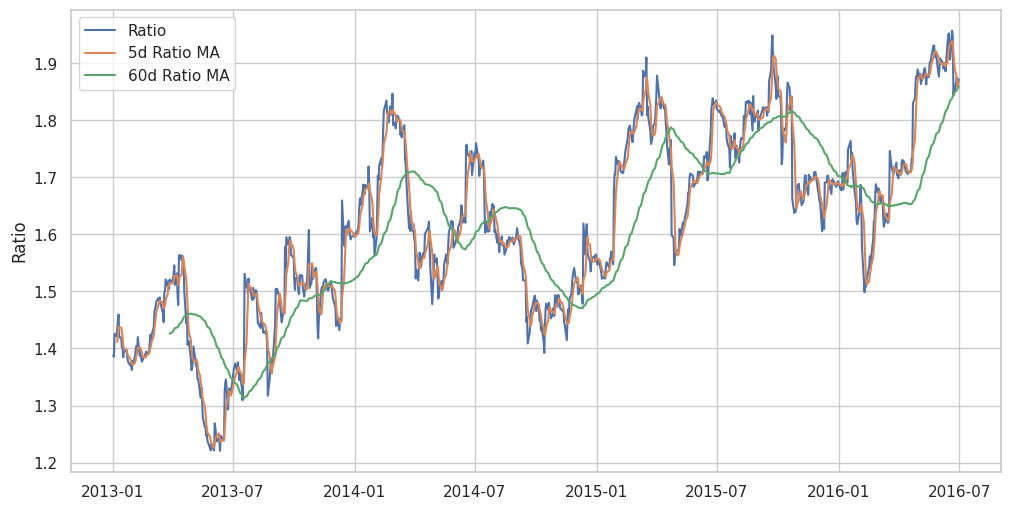

In [ ]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

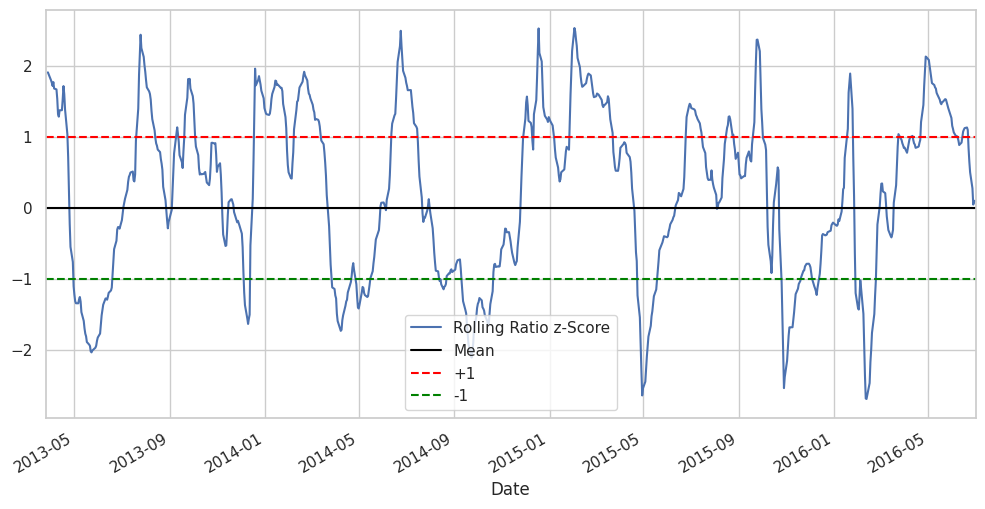

In [ ]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.xlim('2013-03-25', '2016-07-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

**Creating a Model**

A standard normal distribution has a mean of 0 and a standard deviation 1. Looking at the plot, it's pretty clear that if the time series moves 1 standard deviation beyond the mean, it tends to revert back towards the mean.

*Using these models, we can create the following trading signals:*

Buy(1) whenever the z-score is below -1, meaning we expect the ratio to increase.
Sell(-1) whenever the z-score is above 1, meaning we expect the ratio to decrease.

**Model Optimization**

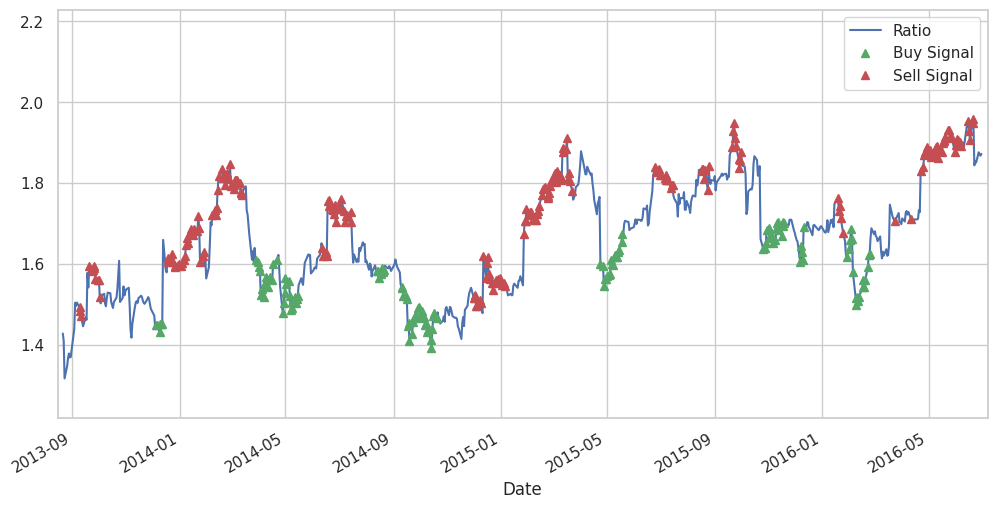

In [ ]:
plt.figure(figsize=(12,6))

train[160:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.xlim('2013-08-15','2016-07-07')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

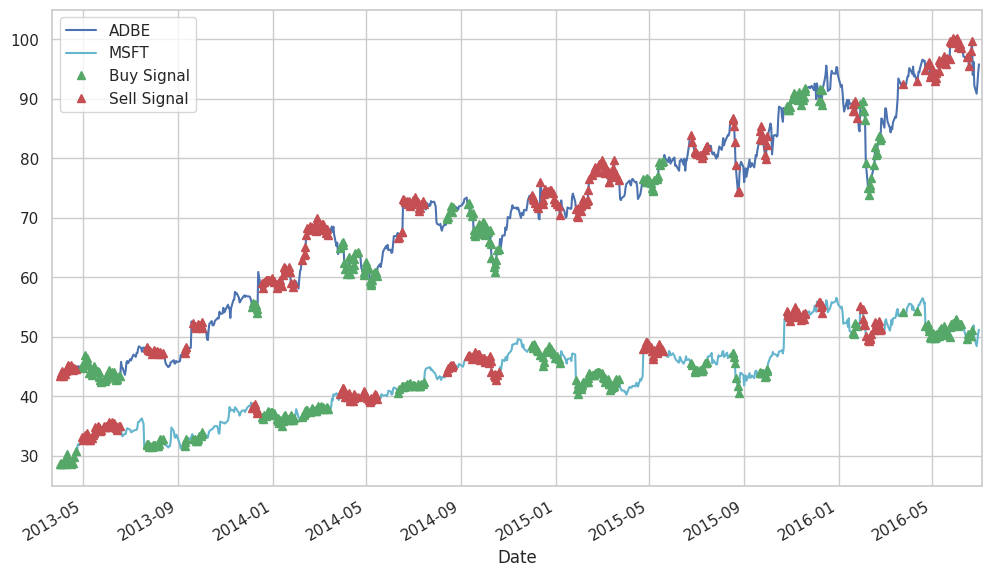

In [ ]:
plt.figure(figsize=(12,7))
S1 = df['ADBE'].iloc[:881]
S2 = df['MSFT'].iloc[:881]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(25, 105)
plt.xlim('2013-03-22', '2016-07-04')

plt.legend(['ADBE', 'MSFT', 'Buy Signal', 'Sell Signal'])
plt.show()

**How Profitable is this Trading Strategy?**



In [ ]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):

    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0

    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std

    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))


    return money

In [ ]:
trade(df['ADBE'].iloc[881:], df['MSFT'].iloc[881:], 60, 5)

451.8561468487711